In [1]:
import theano.tensor as tt
import pymc3 as pm
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt

def planck_radiation(wav, T, h, c, k):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a / ((np.power(wav,5)) * (np.exp(b) - 1.0))
    return intensity

def planck_radiation_tt(wav, T, h, c, k):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a / ((tt.power(wav,5)) * (tt.exp(b) - 1.0))
    return intensity

def gaussian(wave, A, mu, sig):
    return A * np.exp(-np.power(wave - mu, 2.) / (2 * np.power(sig, 2.)))

# Physical constants
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

# Observed wavelength range
obs_wave = np.arange(400,500)

# Compute stellar continuum
T_true = 10000.0
continuum_true = planck_radiation(obs_wave * 1e-9, T_true, h, c, k)

# Calculate line true shape and area
A_true, mu_true, sig_true = 1e15, 460, 1
sqrt2pi = np.sqrt((2 * np.pi))
emline_true = gaussian(obs_wave, A_true, mu_true, sig_true)
emLineArea_true = A_true*sig_true*sqrt2pi
emLineArea_err = emLineArea_true * 0.05

# Mask for the line region
idcs_mask = (obs_wave > mu_true-5) & (obs_wave < mu_true+5)
mask = np.ones(obs_wave.size)
mask[idcs_mask] = 0

# Observed flux with noise
err_continuum = np.mean(continuum_true) * 0.05
obs_flux = continuum_true + emline_true + np.random.normal(0, err_continuum, obs_wave.size)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


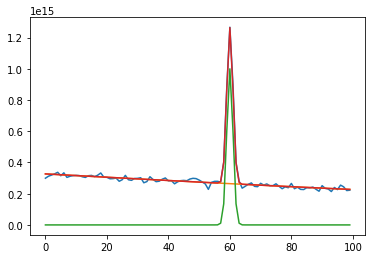

In [2]:
plt.plot(obs_flux)
plt.plot(continuum_true)
plt.plot(emline_true)
plt.plot(continuum_true + emline_true);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, A_norm, temp]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:21<00:00, 275.14draws/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


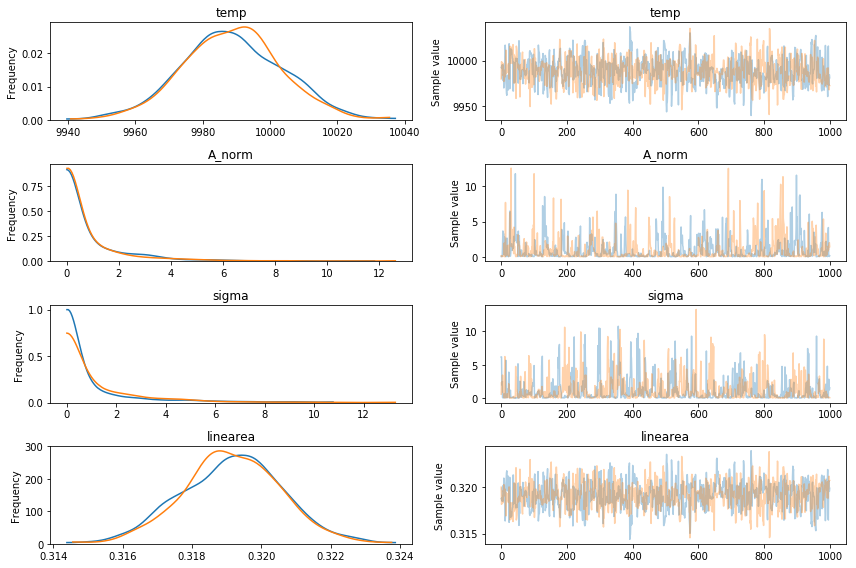

In [3]:
# Pymc3 model
mask_loc = np.where(idcs_mask)[0]
with pm.Model() as model:
    # parameters
    temp = pm.Normal('temp', mu=5000.0, sd=1000.0)
    A_norm = pm.HalfNormal('A_norm', sd=5)
    sig = pm.HalfNormal('sigma', sd=5)

    # Model continuum
    continuum_flux = planck_radiation_tt(obs_wave * 1e-9, temp, h, c, k)

    Y_continuum = pm.Normal('Y_continuum', mu=continuum_flux *
                            mask, sd=err_continuum, observed=obs_flux * mask)

    # Remove from the observation the proposed continuum
    emission_obs = obs_flux - continuum_flux

    # Integrate the line area
    line_area_obs = pm.Deterministic('linearea',
                                     tt.sum(emission_obs[mask_loc]) / (obs_wave[mask_loc[-1]] - obs_wave[mask_loc[0]]) / 1e15)

    # Model line area
    line_area = A_norm * sig * sqrt2pi

    # Global multivariable likelihood for all lines
    Y_line = pm.Normal('Y_line', mu=line_area,
                       sd=emLineArea_err / 1e15, observed=line_area_obs)

    # Launch model
    trace = pm.sample(1000, tune=2000)

# Output trace data
pm.traceplot(trace)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [err, mu, sigma, A_norm, temp]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:31<00:00, 188.72draws/s]


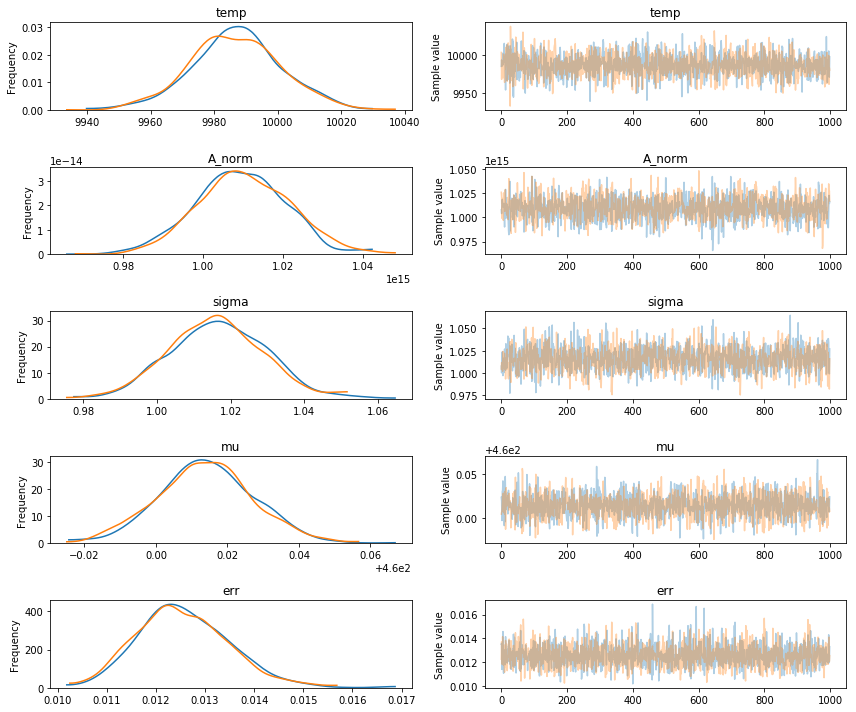

In [4]:
def gaussian_tt(wave, A, mu, sig):
    return A * tt.exp(-tt.power(wave - mu, 2.) / (2 * tt.power(sig, 2.)))


with pm.Model() as model:
    temp = pm.Normal('temp', mu=5000.0, sd=1000.0)
    A_norm = pm.HalfFlat('A_norm')
    sig = pm.HalfNormal('sigma', sd=5)
    mu = pm.Uniform('mu', 400, 500)
    err = pm.HalfNormal('err', 1.)
    # Model continuum
    continuum_latent = planck_radiation_tt(obs_wave * 1e-9, temp, h, c, k)
    emline_latent = gaussian_tt(obs_wave, A_norm, mu, sig)

    # Likelihood
    obs = pm.Normal('obs',
                    mu=(continuum_latent + emline_latent) / 1e15,
                    sd=err,
                    observed=obs_flux / 1e15)

    # Launch model
    trace = pm.sample(1000, tune=2000)

# Output trace data
pm.traceplot(trace)
plt.show()

In [5]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
temp,9.986690e+03,1.410879e+01,2.838179e-01,9.960077e+03,1.001663e+04,2271.357744,0.999986
A_norm,1.009677e+15,1.144462e+13,2.833046e+11,9.870033e+14,1.031346e+15,1654.994605,1.003874
sigma,1.016187e+00,1.299156e-02,3.517472e-04,9.902591e-01,1.040097e+00,1536.414572,1.001362
mu,4.600139e+02,1.321626e-02,2.628134e-04,4.599881e+02,4.600401e+02,2283.835259,1.000210
err,1.255630e-02,9.301868e-04,2.011441e-05,1.083601e-02,1.440866e-02,2433.624509,1.000723
